# Introduction

This notebook is part of a Kaggle challenge. 

We were asked to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system. <br>
You can find more information [here](https://www.kaggle.com/competitions/spaceship-titanic).

In [1]:
# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import urllib.request
import time
import missingno as msno
import warnings

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [2]:
mpl.rc("axes", labelsize=12, titlesize=14)
mpl.rc("figure", figsize=(8, 4))

sns.set_style("darkgrid")
sns.set_palette("muted")

warnings.filterwarnings("ignore")

# Data

## Loading data

In [3]:
file_list = ["train.csv", "test.csv"]
path = os.path.join("Datasets", "Spaceship Titanic")
download_url = "https://raw.githubusercontent.com/gfacheti/ML-Spaceship-Titanic/master/"

def fetch_data(url=download_url, path=path):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in file_list:
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_data()

In [4]:
def load_data(filename, path=path):
    csv_path = os.path.join(path, filename)
    return pd.read_csv(csv_path)

In [5]:
train = load_data("train.csv")
test = load_data("test.csv")

In [6]:
print("Train set shape:", train.shape)
print("Test set shape:", test.shape)
train.head()

Train set shape: (8693, 14)
Test set shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Feature descriptions:
- __PassengerId__ - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- __HomePlanet__ - The planet the passenger departed from, typically their planet of permanent residence.
- __CryoSleep__ - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- __Cabin__ - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- __Destination__ - The planet the passenger will be debarking to.
- __Age__ - The age of the passenger.
- __VIP__ - Whether the passenger has paid for special VIP service during the voyage.
- __RoomService, FoodCourt, ShoppingMall, Spa, VRDeck__ - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- __Name__ - The first and last names of the passenger.
- __Transported__ - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### Basic statistics

In [7]:
print("TRAIN DATASET")
display(train.describe())
print("")
print("TEST DATASET")
display(test.describe())

TRAIN DATASET


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000



TEST DATASET


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


Since there is a significant difference between min and max values in the columns RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck, we need to standardize them

### Missing values

In [8]:
print(train.info())
print("")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null C

In [9]:
print(train.isna().sum())
print("")
print(test.isna().sum())

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


Almost every column has missing values. We need to deal with them.

### Duplicates

In [10]:
print("Duplicates in train set:", train.duplicated().sum())
print("Duplicates in test set:", test.duplicated().sum())

Duplicates in train set: 0
Duplicates in test set: 0


### Cardinality 

There are 6 continuous features, 4 categorical features (excluding the target) and 3 descriptive/qualitative features.

In [11]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

### Data types

In [12]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

We need to transform the data to be numeric, so that we can train machine learning models.

## Exploratory Data Analysis

### Numerical features

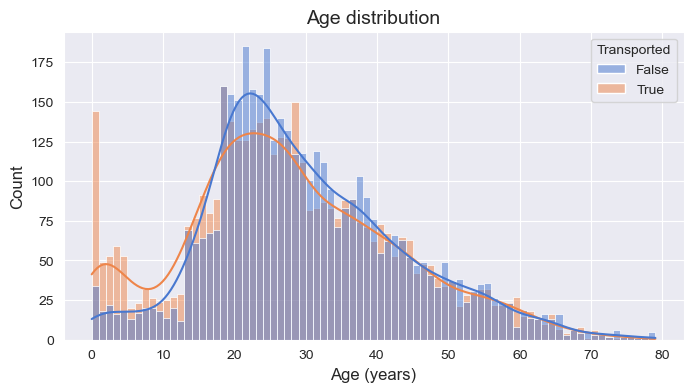

In [13]:
sns.histplot(data=train, x="Age", hue="Transported", binwidth=1, kde=True)
plt.title("Age distribution")
plt.xlabel("Age (years)")

plt.show()

- 0-18 years: were more likely to be transported
- 18-40 years: were less likely to be transported
- Over 40 years: were about equally likely to be transported or not

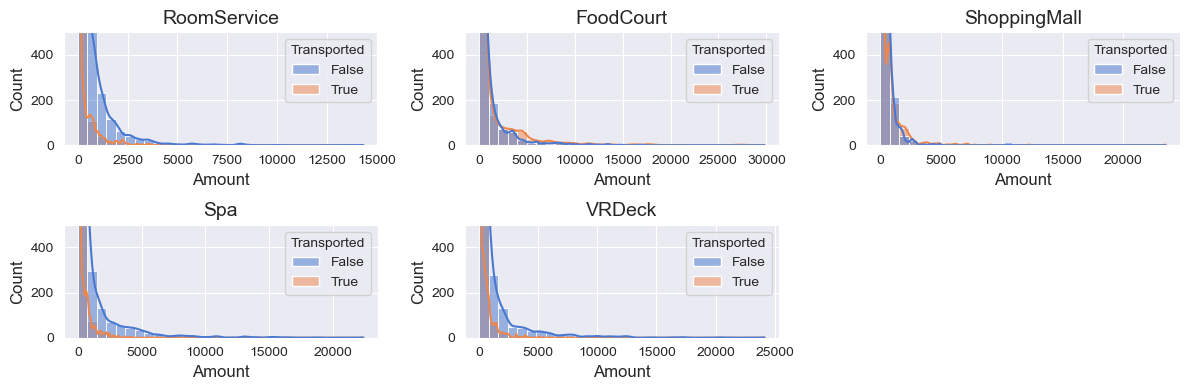

In [14]:
num_features = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

fig = plt.figure(figsize=(12, 4))
for i, var_name in enumerate(num_features):
    ax = fig.add_subplot(2, 3, i+1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue="Transported")
    plt.ylim((0, 500))
    ax.set_xlabel("Amount")
    ax.set_title(var_name)

fig.tight_layout()
plt.show()

- Most people didn't spend any money
- The distribution of spending decays exponentially
- There are outliers, but they are in a small number
- In general, people who were transported tended to spend less
- RoomService, Spa and VRDeck have different distributions to FoodCourt and ShoppingMall

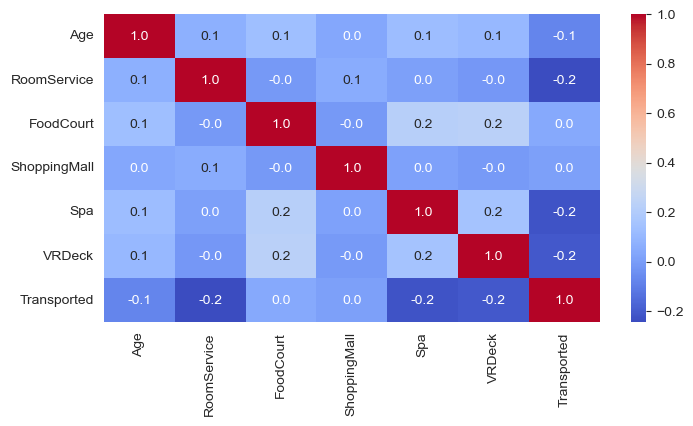

In [15]:
sns.heatmap(train.corr(), annot=True, fmt=".1f", cmap="coolwarm")

plt.show()

There is either a weak correlation or no correlation at all between numerical features, so that won't be a problem.

### Categorical features 

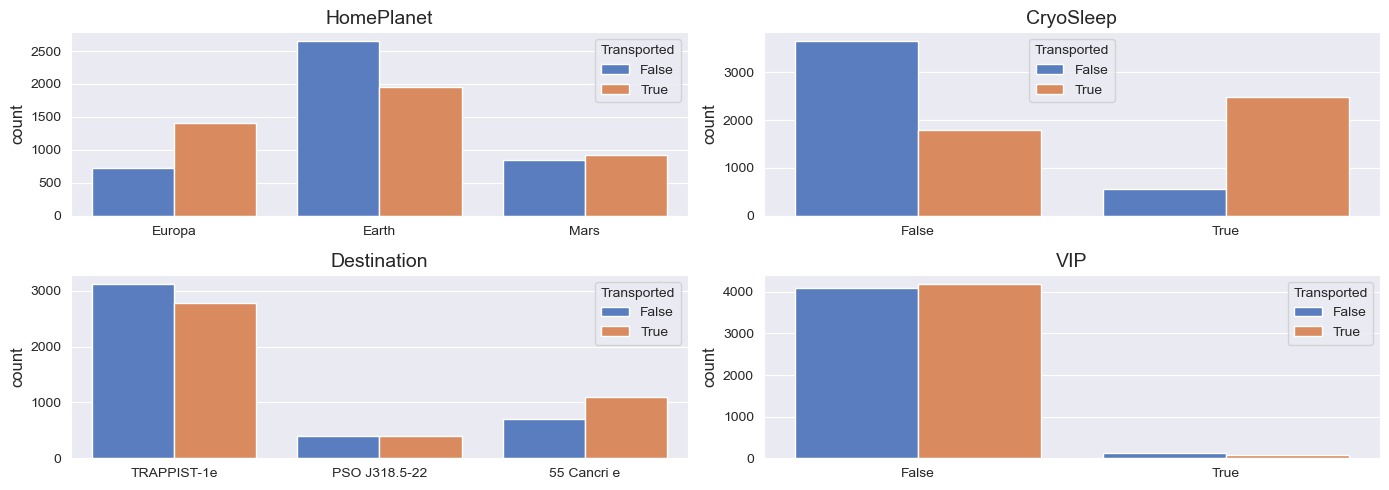

In [16]:
cat_features = ["HomePlanet", "CryoSleep", "Destination", "VIP"]

fig = plt.figure(figsize=(14, 5))
for i, var_name in enumerate(cat_features):
    ax = fig.add_subplot(2, 2, i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue="Transported")
    ax.set_xlabel("")
    ax.set_title(var_name)

fig.tight_layout()
plt.show()

- We can think of dropping the VIP and Destination features since the target split is more or less equal
- CryoSleep, on the other hand, seems to be a very useful feature

### Qualitative features

In [17]:
qual_features = ["PassengerId", "Cabin", "Name"]

train[qual_features].head() # we can't plot this data

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


- We can extract the group (first four numbers) and group size (last two numbers) from the PassengerId
- From the Cabin feature, we can extract the deck, number and side
- Extract the family name could be an interesting approach too

## Feature engineering

### Age groups

Putting the <i>Age</i> feature into groups can help us when filling in missing values.

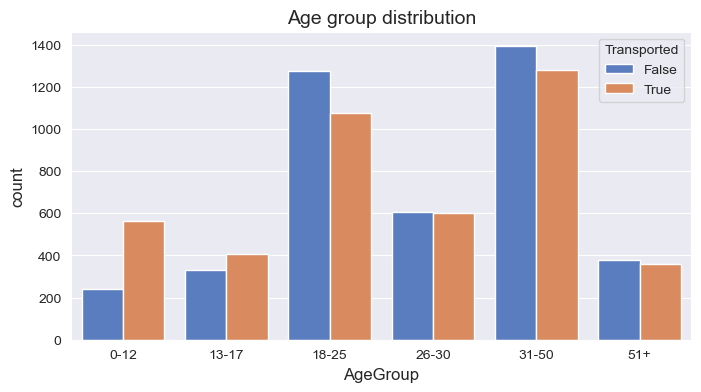

In [18]:
# New feature - AgeGroup
# Train set
train["AgeGroup"] = np.nan
train.loc[train["Age"] <= 12, "AgeGroup"] = "0-12"
train.loc[(train["Age"] > 12) & (train["Age"] < 18), "AgeGroup"] = "13-17"
train.loc[(train["Age"] >= 18) & (train["Age"] <= 25), "AgeGroup"] = "18-25"
train.loc[(train["Age"] > 25) & (train["Age"] <= 30), "AgeGroup"] = "26-30"
train.loc[(train["Age"] > 30) & (train["Age"] <= 50), "AgeGroup"] = "31-50"
train.loc[train["Age"] > 50, "AgeGroup"] = "51+"

# Test set
test["AgeGroup"] = np.nan
test.loc[test["Age"] <= 12, "AgeGroup"] = "0-12"
test.loc[(test["Age"] > 12) & (test["Age"] < 18), "AgeGroup"] = "13-17"
test.loc[(test["Age"] >= 18) & (test["Age"] <= 25), "AgeGroup"] = "18-25"
test.loc[(test["Age"] > 25) & (test["Age"] <= 30), "AgeGroup"] = "26-30"
test.loc[(test["Age"] > 30) & (test["Age"] <= 50), "AgeGroup"] = "31-50"
test.loc[test["Age"] > 50, "AgeGroup"] = "51+"

g = sns.countplot(data=train, x="AgeGroup", hue="Transported", order=["0-12", "13-17", "18-25", "26-30", "31-50", "51+"])
plt.title("Age group distribution")

plt.show()

### Expenditure

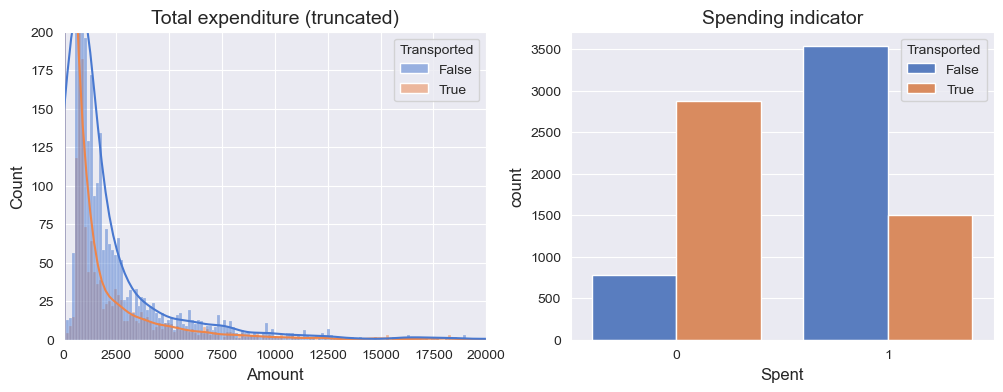

In [19]:
# Train set
train["TotalExpenditure"] = train[num_features].sum(axis=1)
train["Spent"] = (train["TotalExpenditure"] > 0).astype(int)

# Test set
test["TotalExpenditure"] = test[num_features].sum(axis=1)
test["Spent"] = (test["TotalExpenditure"] > 0).astype(int)

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
g = sns.histplot(data=train, x="TotalExpenditure", hue="Transported", kde=True)
g.set(ylim=(0, 200), xlim=(0, 20000), title="Total expenditure (truncated)", xlabel="Amount")

plt.subplot(1, 2, 2)
g2 = sns.countplot(data=train, x="Spent", hue="Transported")
g2.set_title("Spending indicator")

plt.show()

### PassengerId

In [20]:
# New feature - Group
train["Group"] = train["PassengerId"].apply(lambda x: x.split("_")[0]).astype(int)
test["Group"] = test["PassengerId"].apply(lambda x: x.split("_")[0]).astype(int)

# New feature - GroupSize
train["GroupSize"] = train["Group"].map(lambda x: pd.concat([train["Group"], test["Group"]]).value_counts()[x])
test["GroupSize"] = test["Group"].map(lambda x: pd.concat([train["Group"], test["Group"]]).value_counts()[x])

In [21]:
len(train["Group"].unique())

6217

It doesn't make sense to use the <i>Group</i> feature, since it has a big cardinality.

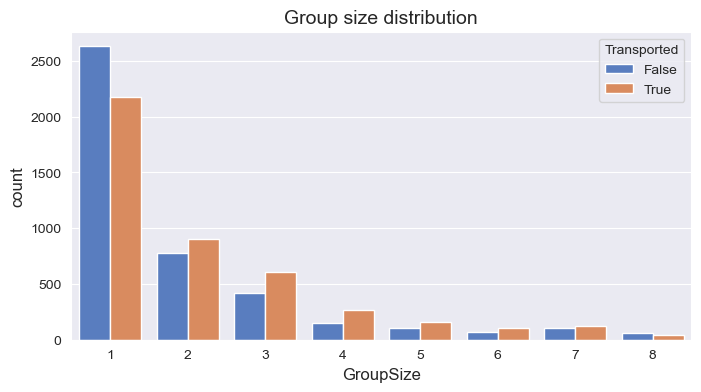

In [22]:
sns.countplot(data=train, x="GroupSize", hue="Transported")
plt.title("Group size distribution")

plt.show()

Apparently, we can compress the <i>GroupSize</i> into a single feature, which tells us if the passenger is traveling solo or not. This will help us deal with missing values and make it easier for the ML models.

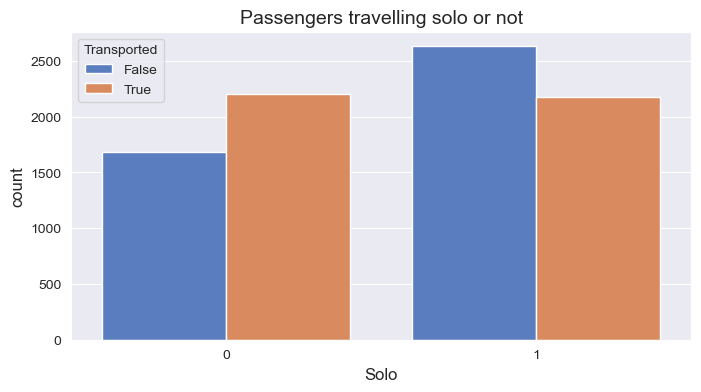

In [23]:
# New feature - Solo
train["Solo"] = (train["GroupSize"] == 1).astype(int)
test["Solo"] = (test["GroupSize"] == 1).astype(int)

sns.countplot(data=train, x="Solo", hue="Transported")
plt.title("Passengers travelling solo or not")

plt.show()

The plot shows us clearly that solo passengers are less likely to be transported than passengers in a group.

### Cabin

In [24]:
# First of all, we need to replace NaNs with something similar to split the feature
train["Cabin"].fillna("Z/9999/Z", inplace=True)
test["Cabin"].fillna("Z/9999/Z", inplace=True)

# Train set
train["CabinDeck"] = train["Cabin"].apply(lambda x: x.split("/")[0])
train["CabinNumber"] = train["Cabin"].apply(lambda x: x.split("/")[1]).astype(int)
train["CabinSide"] = train["Cabin"].apply(lambda x: x.split("/")[2])

# Test set
test["CabinDeck"] = test["Cabin"].apply(lambda x: x.split("/")[0])
test["CabinNumber"] = test["Cabin"].apply(lambda x: x.split("/")[1]).astype(int)
test["CabinSide"] = test["Cabin"].apply(lambda x: x.split("/")[2])

# Now we can put NaNs back in. Later we'll replace them with the mode
train.loc[train["CabinDeck"] == "Z", "CabinDeck"] = np.nan
train.loc[train["CabinNumber"] == 9999, "CabinNumber"] = np.nan
train.loc[train["CabinSide"] == "Z", "CabinSide"] = np.nan
test.loc[test["CabinDeck"] == "Z", "CabinDeck"] = np.nan
test.loc[test["CabinNumber"] == 9999, "CabinNumber"] = np.nan
test.loc[test["CabinSide"] == "Z", "CabinSide"] = np.nan

# We also drop the Cabin feature
train.drop("Cabin", axis=1, inplace=True)
test.drop("Cabin", axis=1, inplace=True)

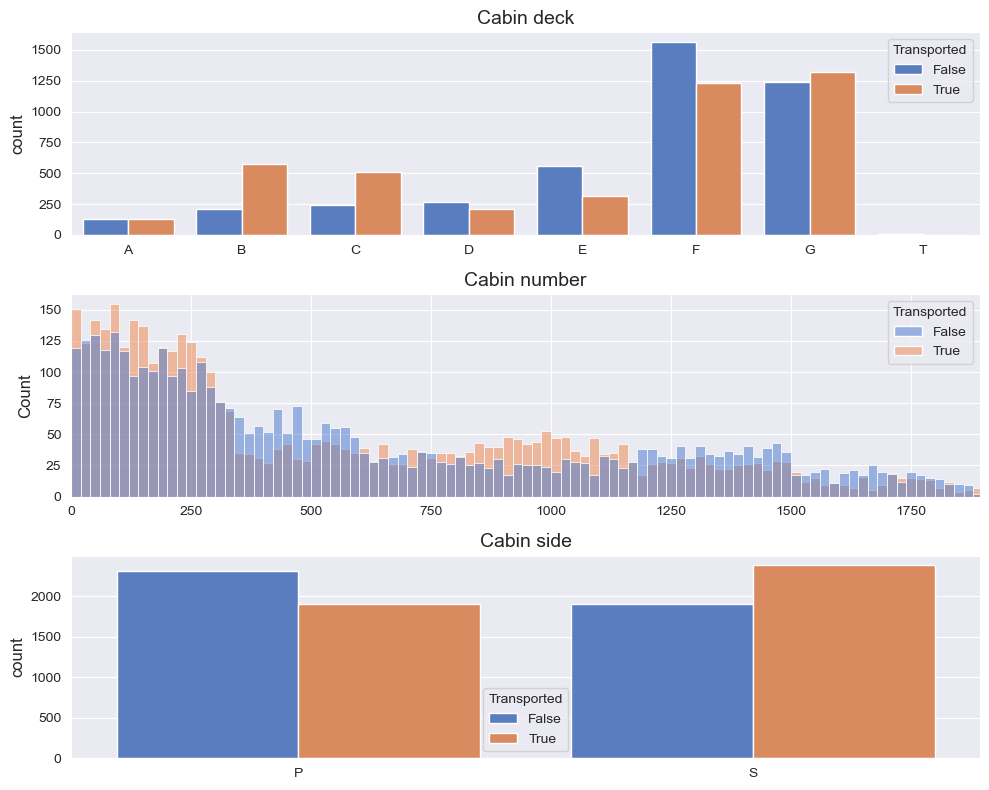

In [25]:
fig = plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
g1 = sns.countplot(data=train, x="CabinDeck", hue="Transported", order=["A", "B", "C", "D", "E", "F", "G", "T"])
g1.set(title="Cabin deck", xlabel="")

plt.subplot(3, 1, 2)
g2 = sns.histplot(data=train, x="CabinNumber", hue="Transported", binwidth=20)
g2.set_xlim(0, max(train["CabinNumber"]))
g2.set(title="Cabin number", xlabel="")

plt.subplot(3, 1, 3)
g3 = sns.countplot(data=train, x="CabinSide", hue="Transported")
g3.set(title="Cabin side", xlabel="")

fig.tight_layout()
plt.show()

It looks like CabinNumber is distributed into chunks. For example, people from cabins 0-300 were more likely to be transported, while those from 300-600 were less likely to be transported. We can create another feature to condense CabinNumber.

In [26]:
# New feature - CabinRegion (using one-hot enconding)
# Train set
train["CabinRegion1"] = (train["CabinNumber"] < 300).astype(int)
train["CabinRegion2"] = ((train["CabinNumber"] >= 300) & (train["CabinNumber"] < 600)).astype(int)
train["CabinRegion3"] = ((train["CabinNumber"] >= 600) & (train["CabinNumber"] < 900)).astype(int)
train["CabinRegion4"] = ((train["CabinNumber"] >= 900) & (train["CabinNumber"] < 1200)).astype(int)
train["CabinRegion5"] = ((train["CabinNumber"] >= 1200) & (train["CabinNumber"] < 1500)).astype(int)
train["CabinRegion6"] = ((train["CabinNumber"] >= 1500) & (train["CabinNumber"] < 1800)).astype(int)
train["CabinRegion7"] = (train["CabinNumber"] >= 1800).astype(int)

# Test set
test["CabinRegion1"] = (test["CabinNumber"] < 300).astype(int)
test["CabinRegion2"] = ((test["CabinNumber"] >= 300) & (test["CabinNumber"] < 600)).astype(int)
test["CabinRegion3"] = ((test["CabinNumber"] >= 600) & (test["CabinNumber"] < 900)).astype(int)
test["CabinRegion4"] = ((test["CabinNumber"] >= 900) & (test["CabinNumber"] < 1200)).astype(int)
test["CabinRegion5"] = ((test["CabinNumber"] >= 1200) & (test["CabinNumber"] < 1500)).astype(int)
test["CabinRegion6"] = ((test["CabinNumber"] >= 1500) & (test["CabinNumber"] < 1800)).astype(int)
test["CabinRegion7"] = (test["CabinNumber"] >= 1800).astype(int)

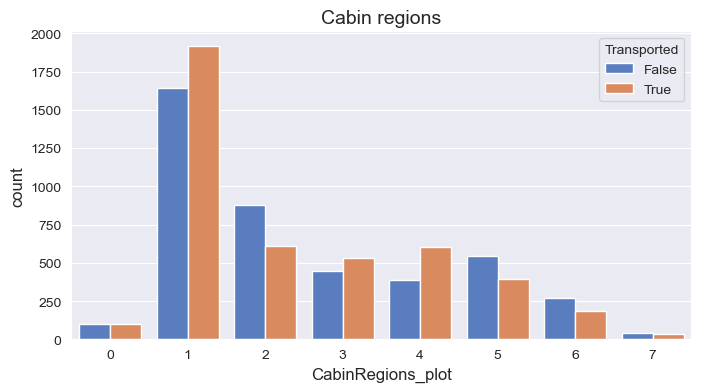

In [27]:
train["CabinRegions_plot"] = (train["CabinRegion1"] + 2*train["CabinRegion2"] + 3*train["CabinRegion3"] + 4*train["CabinRegion4"] + 5*train["CabinRegion5"] + 6*train["CabinRegion6"] + 7*train["CabinRegion7"]).astype(int)
sns.countplot(data=train, x="CabinRegions_plot", hue="Transported")
plt.title("Cabin regions")
train.drop("CabinRegions_plot", axis=1, inplace=True)

plt.show()

### Last name

In [28]:
# First we need to replace NaNs with something, in order to split the name
train["Name"].fillna("Unknown Unknown", inplace=True)
test["Name"].fillna("Unknown Unknown", inplace=True)

# New feature - Surname
train["Surname"] = train["Name"].str.split().str[-1]
test["Surname"] = test["Name"].str.split().str[-1]

# New feature - FamilySize
train["FamilySize"] = train["Surname"].map(lambda x: pd.concat([train["Surname"], test["Surname"]]).value_counts()[x])
test["FamilySize"] = test["Surname"].map(lambda x: pd.concat([train["Surname"], test["Surname"]]).value_counts()[x])

# We can put NaNs back in
train.loc[train["Surname"] == "Unknown", "Surname"] = np.nan
train.loc[train["FamilySize"] > 100, "FamilySize"] = np.nan
test.loc[test["Surname"] == "Unknown", "Surname"] = np.nan
test.loc[test["FamilySize"] > 90, "FamilySize"] = np.nan

# We also drop the Name feature
train.drop("Name", axis=1, inplace=True)
test.drop("Name", axis=1, inplace=True)

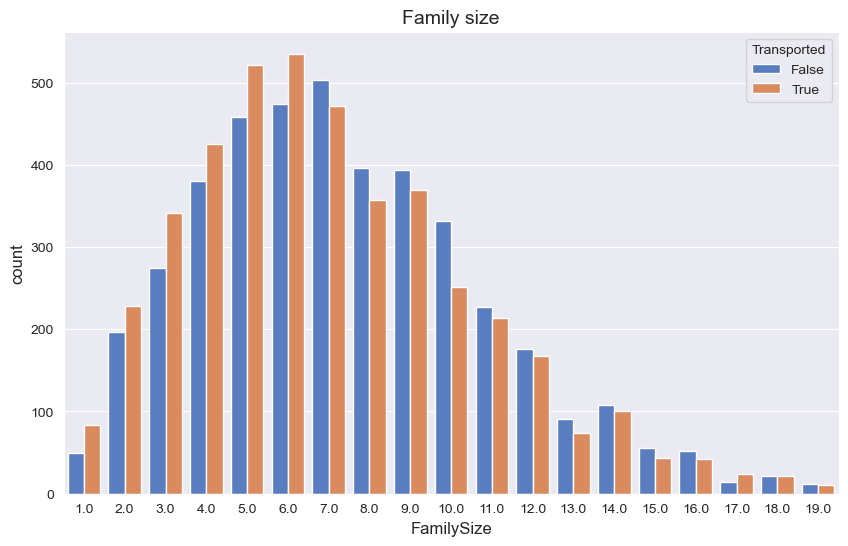

In [29]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x="FamilySize", hue="Transported")
plt.title("Family size")

plt.show()

## Missing values

In [30]:
# Separate labels and features
y = train["Transported"].copy().astype(int)
X = train.drop("Transported", axis=1).copy()

# Concatenate DataFrames
data = pd.concat([X, test], axis=0).reset_index(drop=True)
data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,CabinSide,CabinRegion1,CabinRegion2,CabinRegion3,CabinRegion4,CabinRegion5,CabinRegion6,CabinRegion7,Surname,FamilySize
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,P,1,0,0,0,0,0,0,Ofracculy,3.0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,S,1,0,0,0,0,0,0,Vines,4.0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,S,1,0,0,0,0,0,0,Susent,7.0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,S,1,0,0,0,0,0,0,Susent,7.0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,S,1,0,0,0,0,0,0,Santantines,9.0


### Exploring

In [31]:
# Columns with missing values
na_cols = data.columns[data.isna().any()].tolist()

mv = pd.DataFrame(data[na_cols].isna().sum(), columns=["Number of missing values"])
mv["Percentage of missing values"] = round(100*mv["Number of missing values"]/len(data), 2)
mv

,Number of missing values,Percentage of missing values
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


Missing values make up about 2% of the data, which is a relatively small amount.

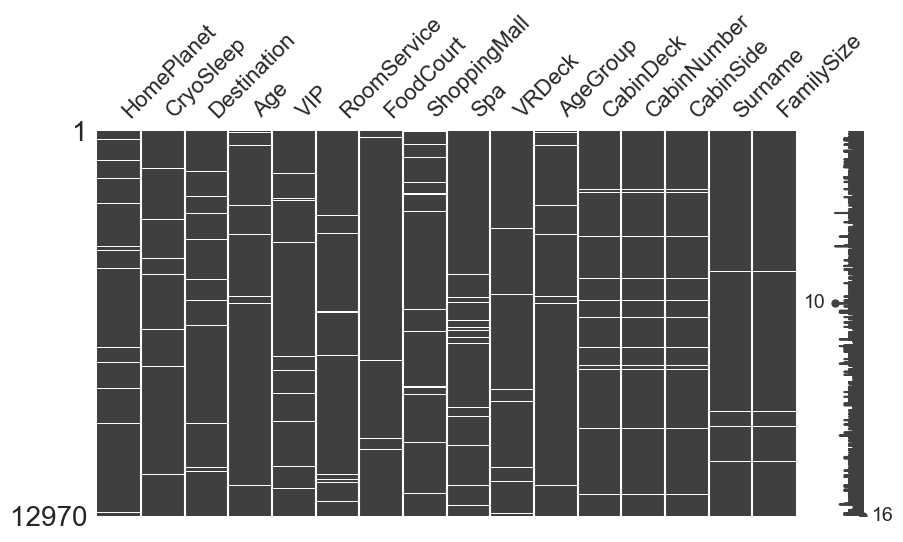

In [32]:
msno.matrix(data[na_cols], figsize=(10, 5))

plt.show()

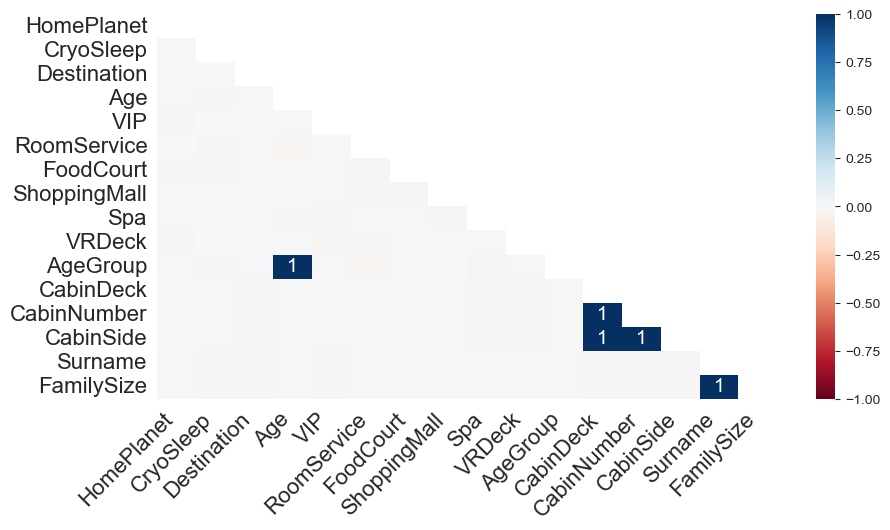

In [33]:
msno.heatmap(data[na_cols], figsize=(10, 5))

plt.show()

We can see that the missing values are independent (excluding the columns we've created), so we can't simply drop rows. We need to explore the data better to see if there's a relationship between the features.

#### HomePlanet and Group

In [34]:
GHP = data.groupby(["Group", "HomePlanet"]).size().unstack().fillna(0)
GHP.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


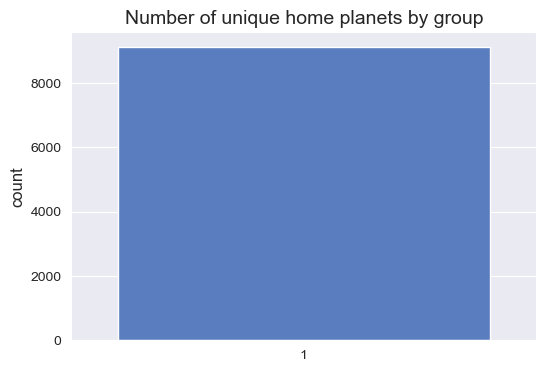

In [35]:
plt.figure(figsize=(6, 4))
sns.countplot(x=(GHP > 0).sum(axis=1))
plt.title("Number of unique home planets by group")

plt.show()

Everyone in the same <i>Group</i> comes from the same <i>HomePlanet</i>! We can use this information to fill in the missing <i>HomePlanet</i> values.

In [36]:
# First, we filter the data to know those indexes where the HomePlanet is missing and, at the same time, is in a Group with known HomePlanet
# For example, Group 64 has two people. The first one, index 58, has the HomePlanet filled in; while the second one, index 59, has not. So this Group is present in GHP and it will return True in GHP_filter
GHP_filter = (data[data["HomePlanet"].isna()]["Group"]).isin(GHP.index)
GHP_index = data[data["HomePlanet"].isna()][GHP_filter].index # Here we have all those index where GHP_filter is True

# Now we need to fill in the missing values based on the Group index (using Mode)
data.loc[GHP_index, "HomePlanet"] = data.iloc[GHP_index, :]["Group"].map(lambda x: GHP.idxmax(axis=1)[x])

# Results
print("HomePlanet missing values before: ", mv.loc["HomePlanet", "Number of missing values"])
print("HomePlanet missing values after: ", data["HomePlanet"].isna().sum())

HomePlanet missing values before:  288
HomePlanet missing values after:  157


#### HomePlanet and CabinDeck

In [37]:
CDHP = data.groupby(["CabinDeck", "HomePlanet"]).size().unstack().fillna(0)
CDHP.T.style.background_gradient(axis=1, cmap="coolwarm")

CabinDeck,A,B,C,D,E,F,G,T
HomePlanet,,,,,,,,
Earth,0.000000,0.000000,0.000000,0.000000,589.000000,2437.000000,3731.000000,0.000000
Europa,352.000000,1137.000000,1096.000000,301.000000,199.000000,0.000000,0.000000,10.000000
Mars,0.000000,0.000000,0.000000,410.000000,515.000000,1742.000000,0.000000,0.000000


- Passengers on decks A, B, C, and T came from Europa
- Passengers on deck G came from Earth
- Passengers on decks D, E, and F came from different planets

In [38]:
# Missing values before
HP_bef = data["HomePlanet"].isna().sum()

# Decks A, B, C, and T came from Europa
data.loc[(data["HomePlanet"].isna()) & (data["CabinDeck"].isin(["A", "B", "C", "T"])), "HomePlanet"] = "Europa"

# Deck G came from Earth
data.loc[(data["HomePlanet"].isna()) & (data["CabinDeck"] == "G"), "HomePlanet"] = "Earth"

# Results
print("HomePlanet missing values before: ", HP_bef)
print("HomePlanet missing values after: ", data["HomePlanet"].isna().sum())

HomePlanet missing values before:  157
HomePlanet missing values after:  94


#### HomePlanet and Surname

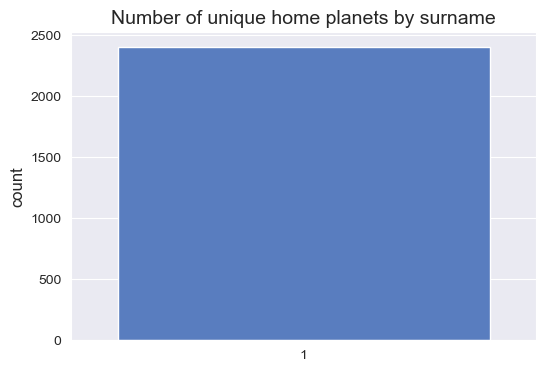

In [39]:
SHP = data.groupby(["Surname", "HomePlanet"]).size().unstack().fillna(0)

plt.figure(figsize=(6, 4))
sns.countplot(x=(SHP > 0).sum(axis=1))
plt.title("Number of unique home planets by surname")

plt.show()

Looking at the plot, we can see that everyone with the same surname came from the same planet.

In [40]:
# Missing values before
HP_bef = data["HomePlanet"].isna().sum()

# First, we filter the data to know those indexes where the HomePlanet is missing and is in a family with known HomePlanet
SHP_filter = (data.loc[data["HomePlanet"].isna()]["Surname"]).isin(SHP.index)
SHP_index = data.loc[data["HomePlanet"].isna()][SHP_filter].index

# Now we need to fill in the missing values based on the Group index (using the mode)
data.loc[SHP_index, "HomePlanet"] = data.iloc[SHP_index, :]["Surname"].map(lambda x: SHP.idxmax(axis=1)[x])

# Results
print("HomePlanet missing values before: ", HP_bef)
print("HomePlanet missing values after: ", data["HomePlanet"].isna().sum())

HomePlanet missing values before:  94
HomePlanet missing values after:  10


Now we have only 10 missing values for <i>HomePlanet</i>. Let's take a look at them.

In [41]:
data.loc[data["HomePlanet"].isna()][["HomePlanet", "Destination", "CabinDeck"]]

,HomePlanet,Destination,CabinDeck
2274,NaN,TRAPPIST-1e,D
2631,NaN,TRAPPIST-1e,F
3091,NaN,TRAPPIST-1e,F
4548,NaN,TRAPPIST-1e,F
5762,NaN,TRAPPIST-1e,F
8969,NaN,TRAPPIST-1e,E
10583,NaN,TRAPPIST-1e,D
11913,NaN,TRAPPIST-1e,E
12551,NaN,TRAPPIST-1e,F
12725,NaN,TRAPPIST-1e,D


Everyone left is going to TRAPPIST-1e! We can fill in the rest of the missing values by joining the features <i>HomePlanet</i> and <i>Destination</i>.

#### HomePlanet and Destination

In [42]:
DHP = data.groupby(["Destination", "HomePlanet"]).size().unstack().fillna(0)
DHP.style.background_gradient(axis=1, cmap="coolwarm")

HomePlanet,Earth,Europa,Mars
Destination,,,
55 Cancri e,1000,1341,300
PSO J318.5-22,1085,29,70
TRAPPIST-1e,4778,1769,2314


Most people heading towards TRAPPIST-1e came from Earth. So it makes sense to use this information to fill in the missing values. BUT no one on deck D came from Earth, so we need to filter these out.

In [43]:
# Missing values before
HP_bef = data["HomePlanet"].isna().sum()

# Fill remaining HomePlanet missing values (Mars if the passenger is on deck D and Earth if not)
data.loc[(data["HomePlanet"].isna()) & (data["CabinDeck"] == "D"), "HomePlanet"] = "Mars"
data.loc[(data["HomePlanet"].isna()) & ~(data["CabinDeck"] == "D"), "HomePlanet"] = "Earth"

# Results
print("HomePlanet missing values before: ", HP_bef)
print("HomePlanet missing values after: ", data["HomePlanet"].isna().sum())

HomePlanet missing values before:  10
HomePlanet missing values after:  0


#### Destination

In [44]:
(data["Destination"].value_counts()/len(data)).apply("{:.2%}".format)

TRAPPIST-1e      68.40%
55 Cancri e      20.36%
PSO J318.5-22     9.13%
Name: Destination, dtype: object

Since almost 70% of the passenges are going to TRAPPIST-1e, we can just impute the mode to replace missing values.

In [45]:
# Fill in missing values with the mode (TRAPPIST-1e)
data.loc[data["Destination"].isna(), "Destination"] = "TRAPPIST-1e"

# Results
print("Destination missing values before: ", mv.loc["Destination", "Number of missing values"])
print("Destination missing values after: ", data["Destination"].isna().sum())

Destination missing values before:  274
Destination missing values after:  0


#### VIP

In [46]:
(data["VIP"].value_counts()/len(data)).apply("{:.2%}".format)

False    95.61%
True      2.10%
Name: VIP, dtype: object

Like <i>Destination</i>, the majority of the passengers are not VIP, so we can just impute the mode.

In [47]:
# Fill in missing values with the mode (False)
data.loc[data["VIP"].isna(), "VIP"] = False

# Results
print("VIP missing values before: ", mv.loc["VIP", "Number of missing values"])
print("VIP missing values after: ", data["VIP"].isna().sum())

VIP missing values before:  296
VIP missing values after:  0


#### Surname and Group

Since we will use surnames to fill in missing values of other features later, we need to replace NaNs here too.

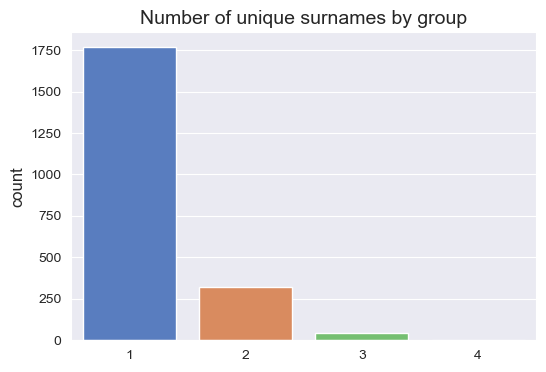

In [48]:
# Let's see how the families are arranged in the Groups
GSN = data.loc[data["GroupSize"] > 1].groupby(["Group", "Surname"]).size().unstack().fillna(0)

plt.figure(figsize=(6, 4))
sns.countplot(x=(GSN > 0).sum(axis=1))
plt.title("Number of unique surnames by group")

plt.show()

It's clear that most groups contain only one family. We can use this insight to fill in the missing surnames.

In [49]:
# First, we filter the data to know those indexes where the Surname is missing and is in a Group with a known Surname
GSN_filter = data.loc[data["Surname"].isna(), "Group"].isin(GSN.index)
GSN_index = data.loc[data["Surname"].isna()][GSN_filter].index

# Fill in corresponding missing values
data.loc[GSN_index, "Surname"] = data.iloc[GSN_index, :]["Group"].map(lambda x: GSN.idxmax(axis=1)[x])


# Results
print("Surname missing values before: ", mv.loc["Surname", "Number of missing values"])
print("Surname missing values after: ", data["Surname"].isna().sum())

Surname missing values before:  294
Surname missing values after:  155


Now we need to update <i>FamilySize</i>.

In [50]:
# Replace NaNs with Unknown first, in order to use map
data["Surname"].fillna("Unknown", inplace=True)

# Update the feature
data["FamilySize"] = data["Surname"].map(lambda x: data["Surname"].value_counts()[x])

# Put NaNs back in
data.loc[data["Surname"] == "Unknown", "Surname"] = np.nan 

# We can also say that unknown surname means no family at all
data.loc[data["FamilySize"] > 100, "FamilySize"] = 0

#### CabinSide and Group

We can combine <i>Group</i> and <i>Cabin</i> (Deck, Side, Number) features to find correlations.

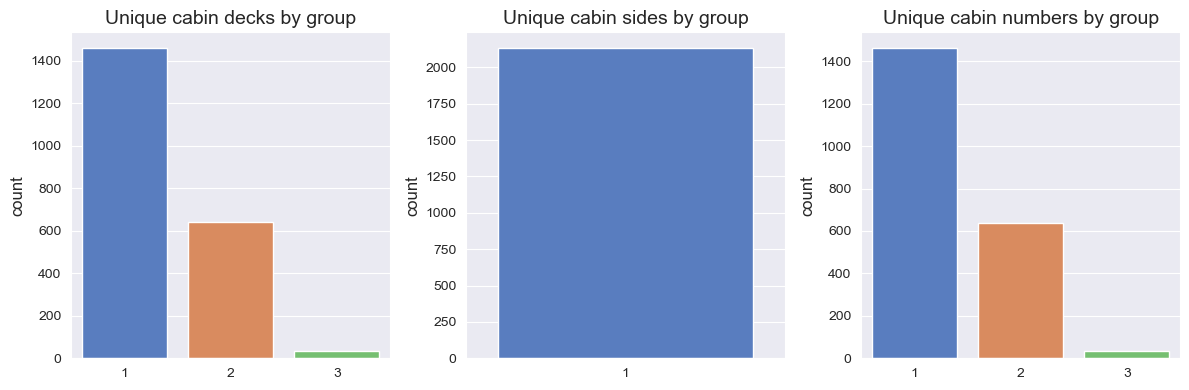

In [51]:
GCD = data.loc[data["GroupSize"] > 1].groupby(["Group", "CabinDeck"]).size().unstack().fillna(0)
GCS = data.loc[data["GroupSize"] > 1].groupby(["Group", "CabinSide"]).size().unstack().fillna(0)
GCN = data.loc[data["GroupSize"] > 1].groupby(["Group", "CabinNumber"]).size().unstack().fillna(0)

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.countplot(x=(GCD > 0).sum(axis=1))
plt.title("Unique cabin decks by group")

plt.subplot(1, 3, 2)
sns.countplot(x=(GCS > 0).sum(axis=1))
plt.title("Unique cabin sides by group")

plt.subplot(1, 3, 3)
sns.countplot(x=(GCN > 0).sum(axis=1))
plt.title("Unique cabin numbers by group")

plt.tight_layout()
plt.show()

Everyone in the same group is in the same cabin side! So we have another rule. <br> 
Also, most groups are distributed in one cabin number and one cabin deck.

In [52]:
# First, we filter the data to know those indexes where the CabinSide is missing and is in a Group with a known CabinSide
GCS_filter = data.loc[data["CabinSide"].isna(), "Group"].isin(GCS.index)
GCS_index = data.loc[data["CabinSide"].isna(), "Group"][GCS_filter].index

# Fill in corresponding missing values
data.loc[GCS_index, "CabinSide"] = data.iloc[GCS_index, :]["Group"].map(lambda x: GCS.idxmax(axis=1)[x])

# Results
print("CabinSide missing values before: ", mv.loc["CabinSide", "Number of missing values"])
print("CabinSide missing values after: ", data["CabinSide"].isna().sum())

CabinSide missing values before:  299
CabinSide missing values after:  162


#### CabinSide and Surname

In [53]:
SCS = data.loc[data["GroupSize"] > 1].groupby(["Surname", "CabinSide"]).size().unstack().fillna(0)

((SCS > 0).sum(axis=1).value_counts()/len(SCS)).apply("{:.2%}".format)

1    76.70%
2    23.30%
dtype: object

76.7% of all families are on the same side. We can use this to fill in missing values.

In [54]:
# Missing values before
CS_bef = data["CabinSide"].isna().sum()

# First, we filter the data to know those indexes where the CabinSide is missing and has a Surname with a known CabinSide
SCS_filter = data.loc[data["CabinSide"].isna(), "Surname"].isin(SCS.index)
SCS_index = data.loc[data["CabinSide"].isna(), "Surname"][SCS_filter].index

# Fill in corresponding missing values
data.loc[SCS_index, "CabinSide"] = data.iloc[SCS_index, :]["Surname"].map(lambda x: SCS.idxmax(axis=1)[x])

# Drop Surname
data.drop("Surname", axis=1, inplace=True)

# Results
print("CabinSide missing values before: ", CS_bef)
print("CabinSide missing values after: ", data["CabinSide"].isna().sum())

CabinSide missing values before:  162
CabinSide missing values after:  66


In [55]:
data["CabinSide"].value_counts()

S    6504
P    6400
Name: CabinSide, dtype: int64

Since the passengers are almost equally distributed on those two sides, it's better to replace the remaining missing values with an outlier, so we don't mess with the correlation.

In [56]:
# Missing values before
CS_bef = data["CabinSide"].isna().sum()

# Fill remaining missing values with outlier
data.loc[data["CabinSide"].isna(), "CabinSide"] = "Z"

# Results
print("CabinSide missing values before: ", CS_bef)
print("CabinSide missing values after: ", data["CabinSide"].isna().sum())

CabinSide missing values before:  66
CabinSide missing values after:  0


#### CabinDeck and Group

As we saw above, groups tend to be on the same cabin deck.

In [57]:
# Missing values before
CD_bef = data["CabinDeck"].isna().sum()

# First, we filter the data to know those indexes where the CabinDeck is missing and is in a Group with a known CabinDeck
GCD_filter = data.loc[data["CabinDeck"].isna(), "Group"].isin(GCD.index)
GCD_index = data.loc[data["CabinDeck"].isna(), "Group"][GCD_filter].index

# Fill in corresponding missing values
data.loc[GCD_index, "CabinDeck"] = data.iloc[GCD_index, :]["Group"].map(lambda x: GCD.idxmax(axis=1)[x])

# Results
print("CabinDeck missing values before: ", CD_bef)
print("CabinDeck missing values after: ", data["CabinDeck"].isna().sum())

CabinDeck missing values before:  299
CabinDeck missing values after:  162


#### CabinDeck and HomePlanet

In [58]:
HPCD = data.groupby(["HomePlanet", "Destination", "Solo", "CabinDeck"]).size().unstack().fillna(0)
HPCD.style.background_gradient(axis=1, cmap="coolwarm")

- Passengers from Mars are most likely on cabin deck F
- Passengers from Europa are almost equally distributed on cabin deck B and C
- Passengers from Earth are most likely on cabin decks G

We can fill in the remaining missing values in <i>CabinDeck</i> using the mode of these subgroups.

In [59]:
# Missing values before
CD_bef = data["CabinDeck"].isna().sum()

# Fill in missing values using the mode
na_index_cd = data.loc[data["CabinDeck"].isna(), "CabinDeck"].index
data.loc[data["CabinDeck"].isna(), "CabinDeck"] = data.groupby(["HomePlanet", "Destination", "Solo"])["CabinDeck"].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_index_cd]

# Results
print("CabinDeck missing values before: ", CD_bef)
print("CabinDeck missing values after: ", data["CabinDeck"].isna().sum())

CabinDeck missing values before:  162
CabinDeck missing values after:  0


#### CabinNumber and CabinDeck

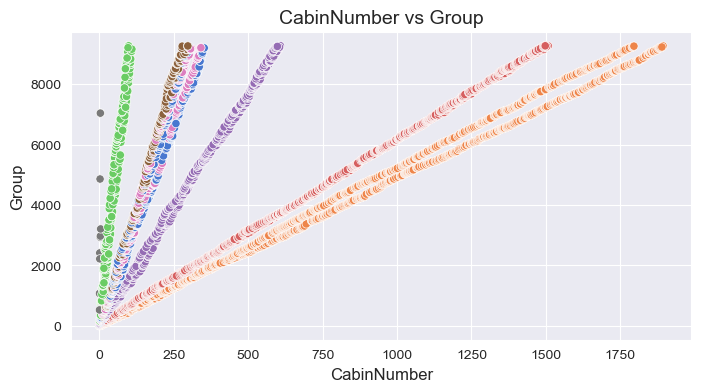

In [60]:
g = sns.scatterplot(x=data["CabinNumber"], y=data["Group"], hue=data.loc[~data["CabinNumber"].isna(),"CabinDeck"])
plt.title("CabinNumber vs Group")
g.get_legend().remove()

plt.show()

Looking at the plot we can see that there's a linear relationship between <i>CabinNumber</i> and <i>Group</i> on a deck. We can use that to predict the missing values in <i>CabinNumber</i> and finally update our feature <i>CabinRegion</i>.

In [61]:
decks = sorted(data.loc[data["CabinNumber"].isna(), "CabinDeck"].unique())

# Extrapolate linear relationship on a deck by deck basis
for deck in decks: # T not included because there are no missing values there
    # Features and labels
    X_CN = data.loc[~(data["CabinNumber"].isna()) & (data["CabinDeck"] == deck), "Group"]
    y_CN = data.loc[~(data["CabinNumber"].isna()) & (data["CabinDeck"] == deck), "CabinNumber"]
    X_test_CN = data.loc[(data["CabinNumber"].isna()) & (data["CabinDeck"] == deck), "Group"]

    # Linear regression
    model_CN = LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1,1), y_CN)
    pred_CN = model_CN.predict(X_test_CN.values.reshape(-1,1))
    
    # Fill in missing values with predictions
    data.loc[(data["CabinNumber"].isna()) & (data["CabinDeck"] == deck), "CabinNumber"] = pred_CN.astype(int)    

# Results
print("CabinNumber missing values before: ", mv.loc["CabinNumber", "Number of missing values"])
print("CabinNumber missing values after: ", data["CabinNumber"].isna().sum())

CabinNumber missing values before:  299
CabinNumber missing values after:  0


In [62]:
# Update CabinRegion feature
data["CabinRegion1"] = (data["CabinNumber"] < 300).astype(int)
data["CabinRegion2"] = ((data["CabinNumber"] >= 300) & (data["CabinNumber"] < 600)).astype(int)
data["CabinRegion3"] = ((data["CabinNumber"] >= 600) & (data["CabinNumber"] < 900)).astype(int)
data["CabinRegion4"] = ((data["CabinNumber"] >= 900) & (data["CabinNumber"] < 1200)).astype(int)
data["CabinRegion5"] = ((data["CabinNumber"] >= 1200) & (data["CabinNumber"] < 1500)).astype(int)
data["CabinRegion6"] = ((data["CabinNumber"] >= 1500) & (data["CabinNumber"] < 1800)).astype(int)
data["CabinRegion7"] = (data["CabinNumber"] >= 1800).astype(int)

#### Age

For <i>Age</i>, we can group <code>data</code> by some columns and take the median to fill in the missing values.

In [63]:
data.groupby(["HomePlanet", "Spent", "Solo", "CabinDeck"])["Age"].median().unstack().fillna(0)

CabinDeck                 A     B     C     D     E     F     G     T
HomePlanet Spent Solo                                                
Earth      0     0      0.0   0.0   0.0   0.0   7.0  16.0   8.0   0.0
                 1      0.0   0.0   0.0   0.0  21.0  21.5  23.0   0.0
           1     0      0.0   0.0   0.0   0.0  24.0  25.0  28.0   0.0
                 1      0.0   0.0   0.0   0.0  25.0  24.0  26.0   0.0
Europa     0     0     30.0  27.0  28.5  27.0  28.0   0.0   0.0   0.0
                 1     37.5  34.0  35.0  31.0  33.0   0.0   0.0   0.0
           1     0     35.0  34.0  33.0  33.0  34.0   0.0   0.0  44.0
                 1     35.0  36.0  35.5  34.0  35.0   0.0   0.0  35.0
Mars       0     0      0.0   0.0   0.0  29.5  26.0  18.0   0.0   0.0
                 1      0.0   0.0   0.0  33.0  30.0  29.5   0.0   0.0
           1     0      0.0   0.0   0.0  30.0  29.0  29.0   0.0   0.0
                 1      0.0   0.0   0.0  31.0  28.5  30.0   0.0   0.0

In [64]:
# Fill in missing values using the median
na_index = data.loc[data["Age"].isna(), "Age"].index
data.loc[data["Age"].isna(), "Age"] = data.groupby(["HomePlanet", "Spent", "Solo", "CabinDeck"])["Age"].transform(lambda x: x.fillna(x.median()))[na_index]

# Results
print("Age missing values before: ", mv.loc["Age", "Number of missing values"])
print("Age missing values after: ", data["Age"].isna().sum())

Age missing values before:  270
Age missing values after:  0


In [65]:
# Update AgeGroup feature
data.loc[data["Age"] <= 12,"AgeGroup"] = "0-12"
data.loc[(data["Age"] > 12) & (data["Age"] < 18), "AgeGroup"] = "13-17"
data.loc[(data["Age"] >= 18) & (data["Age"] <= 25), "AgeGroup"] = "18-25"
data.loc[(data["Age"] > 25) & (data["Age"] <= 30), "AgeGroup"] = "26-30"
data.loc[(data["Age"] > 30) & (data["Age"] <= 50), "AgeGroup"] = "31-50"
data.loc[data["Age"] > 50, "AgeGroup"] = "51+"

#### CryoSleep

This feature is easier to predict because we just need to see if they spent anything.

In [66]:
data.groupby(["Spent", "CryoSleep"]).size().unstack().fillna(0)

CryoSleep,False,True
Spent,,
0,740.0,4581.0
1,7339.0,0.0


In [67]:
# Missing values before
CS_bef = data["CryoSleep"].isna().sum()

# Fill missing values using the mode
# First, we get the index of all missing values in CryoSleep
CS_index = data.loc[data["CryoSleep"].isna(), "CryoSleep"].index

# Now we group the data by Spent and select the CryoSleep column to take the mode 
data.loc[data["CryoSleep"].isna(), "CryoSleep"] = data.groupby("Spent")["CryoSleep"].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[CS_index]
        # pd.Series.mode(x)[0] takes only the mode (in this case, True or False) from each group
        # [CS_index] is used to filter just the wanted rows

# Results
print("CryoSleep missing values before: ", CS_bef)
print("CryoSleep missing values after: ", data["CryoSleep"].isna().sum())

CryoSleep missing values before:  310
CryoSleep missing values after:  0


#### Expenditure and CryoSleep

Since no one in cryo sleep spent money, it makes sense to fill in all rows in <code>num_features</code> with 0.

In [68]:
# Missing values before
E_bef = data[num_features].isna().sum().sum()

# Replace NaN with 0 for those in cryo sleep
for col in num_features:
    data.loc[(data[col].isna()) & (data["CryoSleep"] == True), col] = 0
    
# Results
print("Expenditure missing values before: ", E_bef)
print("Expenditure missing values after: ", data[num_features].isna().sum().sum())

Expenditure missing values before:  1410
Expenditure missing values after:  866


#### Expenditure and others

For the remaining missing values in <code>num_features</code>, we can use the mean to fill them in.

In [69]:
data.groupby(["HomePlanet", "Solo", "AgeGroup"])["TotalExpenditure"].mean().unstack().fillna(0)

AgeGroup         0-12        13-17        18-25        26-30        31-50  \
HomePlanet Solo                                                             
Earth      0      0.0   724.902222   789.700555   841.093596   736.655773   
           1      0.0   693.014898   779.395942   795.420690   794.818627   
Europa     0      0.0  1153.160256  2652.013298  3534.668246  3975.774005   
           1      0.0     0.000000  2489.888889  3806.000000  3949.939929   
Mars       0      0.0  1176.839286  1161.808333  1247.098361  1143.671916   
           1      0.0  1687.261538  1075.341146  1107.122677  1110.392045   

AgeGroup                 51+  
HomePlanet Solo               
Earth      0      733.649573  
           1      826.366972  
Europa     0     3483.639004  
           1     3952.085526  
Mars       0     1345.419643  
           1     1100.298387

In [70]:
# Missing values before
E_bef = data[num_features].isna().sum().sum()

# Replace NaN with the mean of every column in num_features
for col in num_features:
    na_index = data.loc[data[col].isna(), col].index
    data.loc[data[col].isna(), col] = data.groupby(["HomePlanet", "Solo", "AgeGroup"])[col].transform(lambda x: x.fillna(x.mean()))[na_index]
    
# Results
print("Expenditure missing values before: ", E_bef)
print("Expenditure values after: ", data[num_features].isna().sum().sum())

Expenditure missing values before:  866
Expenditure values after:  0


In [71]:
# Update Expenditure and Spent features with these new values.
data["TotalExpenditure"] = data[num_features].sum(axis=1)
data["Spent"] = (data["TotalExpenditure"] > 0).astype(int)

In [72]:
data.isna().sum()

PassengerId         0
HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
AgeGroup            0
TotalExpenditure    0
Spent               0
Group               0
GroupSize           0
Solo                0
CabinDeck           0
CabinNumber         0
CabinSide           0
CabinRegion1        0
CabinRegion2        0
CabinRegion3        0
CabinRegion4        0
CabinRegion5        0
CabinRegion6        0
CabinRegion7        0
FamilySize          0
dtype: int64

Nice! No missing values left. Now we can preprocess the data and train our models.

# Preprocessing

In [73]:
# Split data back into train and test
X = data.loc[data["PassengerId"].isin(train["PassengerId"].values)].copy()
X_test = data.loc[data["PassengerId"].isin(test["PassengerId"].values)].copy()

In [74]:
# Drop unwanted features
X.drop(["PassengerId", "Group", "GroupSize", "AgeGroup", "CabinNumber"], axis=1, inplace=True)
X_test.drop(["PassengerId", "Group", "GroupSize", "AgeGroup", "CabinNumber"], axis=1, inplace=True)

## Log transform

We saw in the beginning that the continuous features are really skewed - most people spent just a little, but there are a lot of outliers. That is bad for ML models. 

We can use the logarithm transform to "remove" those outliers. Let's see how it works.

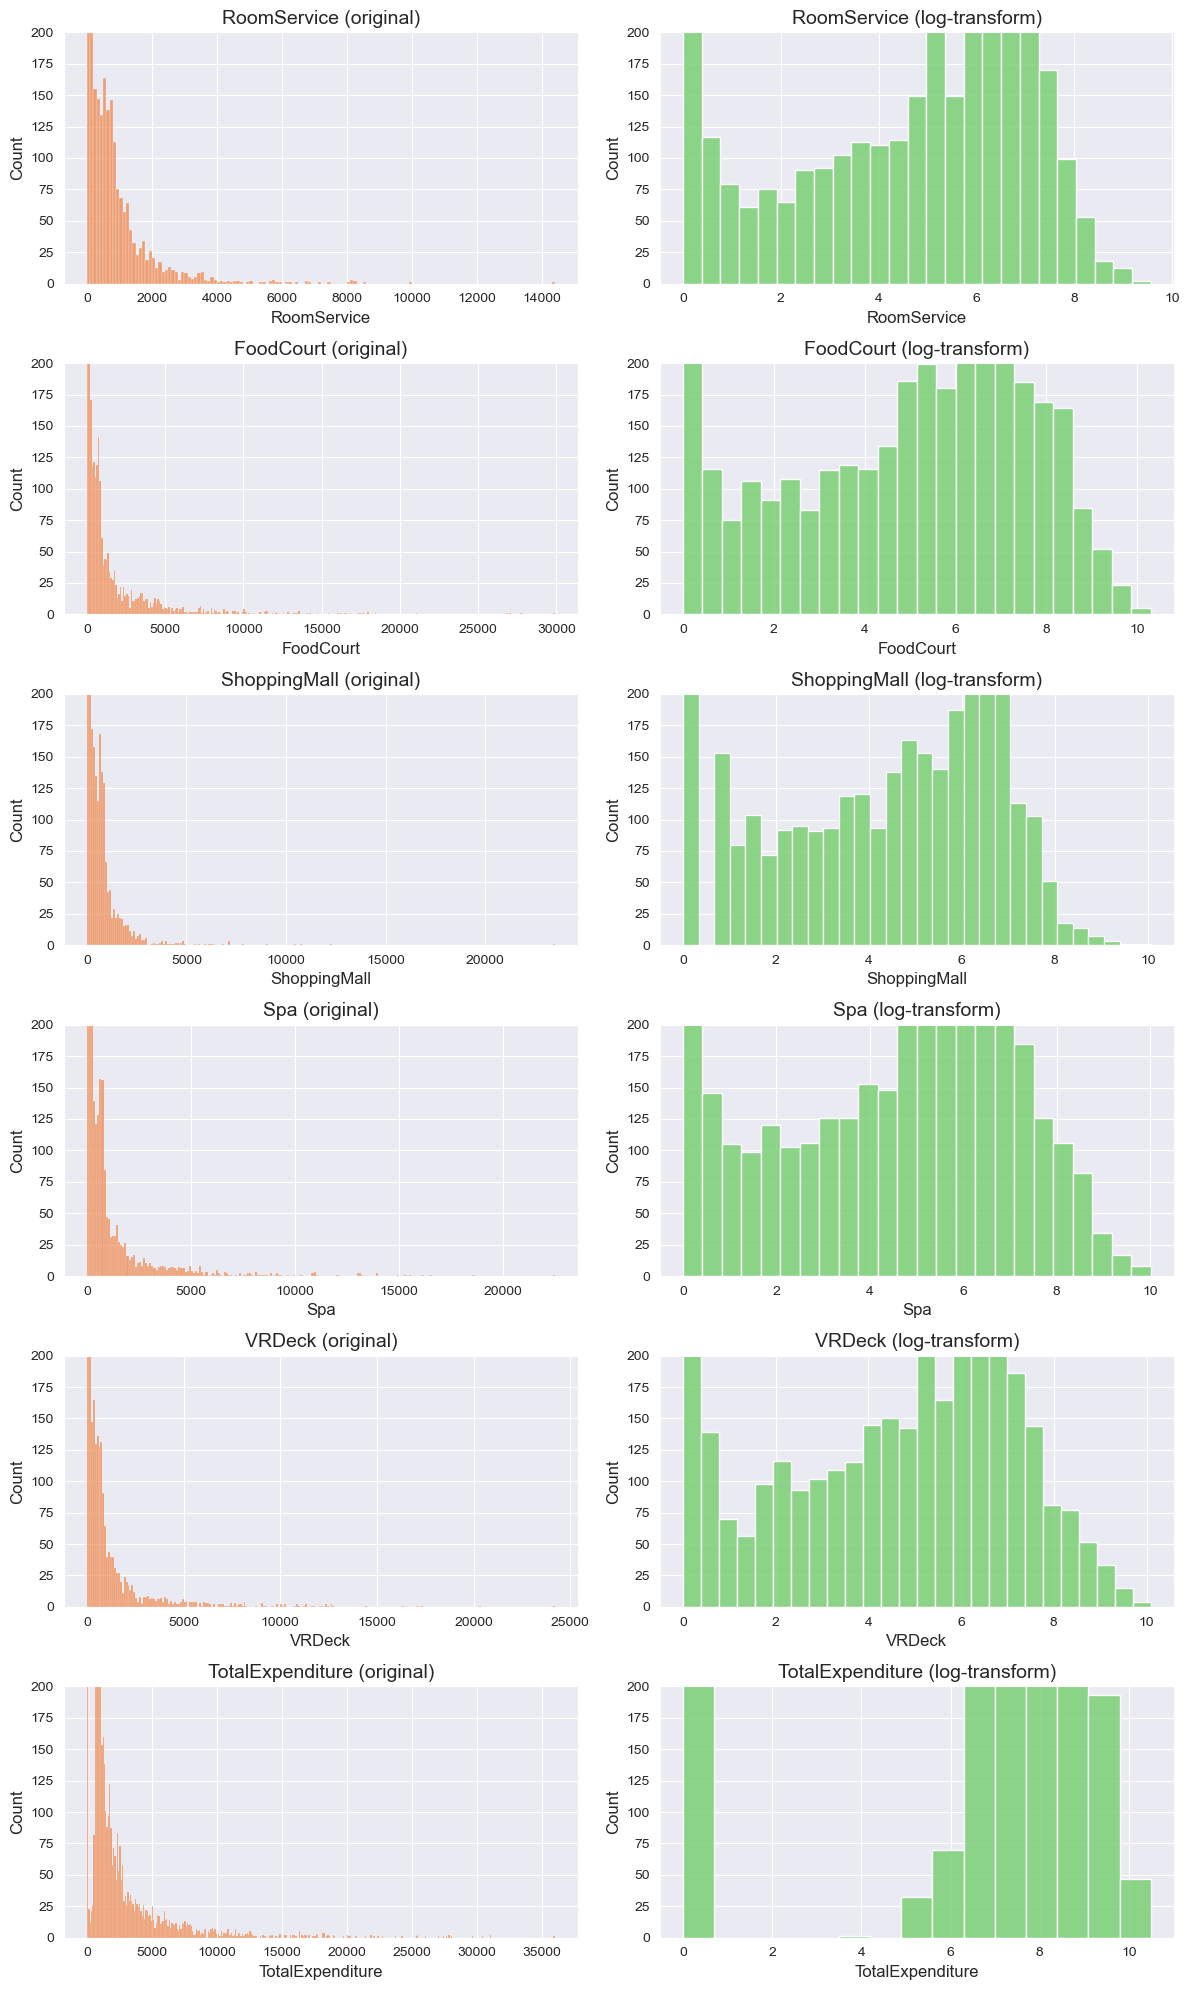

In [75]:
fig = plt.figure(figsize=(12, 20))
for i, col in enumerate(["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "TotalExpenditure"]):
    plt.subplot(6, 2, 2*i+1)
    sns.histplot(X[col], binwidth=100, color="C1")
    plt.ylim(0, 200)
    plt.title(f"{col} (original)")
    
    plt.subplot(6, 2, 2*i+2)
    sns.histplot(np.log(1 + X[col]), color="C2")
    plt.ylim(0, 200)
    plt.title(f"{col} (log-transform)")
    
fig.tight_layout()
plt.show()

Looks better! Surely it'll help our models. Let's apply it to those features.

In [76]:
for col in ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "TotalExpenditure"]:
    X[col] = np.log(1 + X[col])
    X_test[col] = np.log(1 + X_test[col])

## Encoding and scaling

In [77]:
# Get numerical and categorical columns
num_cols = [col for col in X.columns if X[col].dtype in ["int32", "int64", "float64"]]
cat_cols = [col for col in X.columns if X[col].dtype == "object"]

# Pipeline
# Standardize numerical features by removing the mean and scaling to unit variance
num_pipeline = Pipeline(steps=[("scaler", StandardScaler())])

# Encode categorical features as a one-hot numeric array
cat_pipeline = Pipeline(steps=[("onehot", OneHotEncoder(drop="if_binary", sparse_output=False, handle_unknown="ignore"))])

# Use ColumnTransformer -> (name, transformer, columns)
col_transf = ColumnTransformer(
        transformers=[
            ("num", num_pipeline, num_cols), 
            ("cat", cat_pipeline, cat_cols)], 
            remainder='passthrough')

# Apply all steps
X = col_transf.fit_transform(X)
X_test = col_transf.transform(X_test) # We don't fit the test set

print("Training set shape:", X.shape)

Training set shape: (8693, 36)


## Split

It's a good practice to create a validation set.

In [78]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model selection

In [79]:
# Classifiers
# After some tries, I removed XGBoost and MLPClassifier because they take too long to run
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42), 
    "SVC": SVC(random_state=42, kernel="rbf", probability=True), 
    "KNN": KNeighborsClassifier(),
    "LGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=False, thread_count=4)
}

# Grid to search for
grid = {
    "LogisticRegression": {"penalty": ["l1", "l2"], 
                            "C": [0.25, 0.5, 0.75, 1, 1.25, 1.5], 
                            "max_iter": [50, 100, 150]}, 
    "DecisionTree": {"criterion": ["gini", "entropy"],
                      "max_depth": [2, 4, 6, 8, 10, 12]},
    "AdaBoost": {"n_estimators": [50, 100, 150, 200, 250, 300]},
    "RandomForest": {"n_estimators": [50, 100, 150, 200, 250, 300],
                     "max_depth": [2, 4, 6, 8, 10, 12]},
    "SVC": {"C": [0.5, 0.75, 1, 1.25, 1.5],
            "gamma": ["scale", "auto"]},
    "KNN": {"n_neighbors": [3, 5, 7, 9],
            "p": [1, 2]},    
    "LGBM": {"n_estimators": [50, 100, 150, 200],
             "max_depth": [4, 8, 12],
             "learning_rate": [0.05, 0.1, 0.15]},
    "CatBoost": {"iterations": [100, 200, 300],
                 "learning_rate": [0.05, 0.1, 0.15],
                 "depth": [4, 6, 8]}
}

In [80]:
# Create a DataFrame to store the results
results = pd.DataFrame({"Classifier": classifiers.keys(), "Accuracy": np.empty(len(classifiers)), "ROC AUC": np.empty(len(classifiers)), "F1 Score": np.empty(len(classifiers)), "Training time (s)": np.empty(len(classifiers))})

# Dict to store the best parameters
clf_best_params = classifiers.copy()

print("Training time")
print("------------------------------------")
i = 0
for key, classifier in classifiers.items():
    t0 = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=5)
    
    # Fit and score
    clf.fit(X_train, y_train)
    results.iloc[i, 1] = clf.score(X_val, y_val)
    results.iloc[i, 2] = roc_auc_score(y_val, clf.predict(X_val))
    results.iloc[i, 3] = f1_score(y_val, clf.predict(X_val))
    
    # Save trained model
    clf_best_params[key] = clf.best_params_
    
    # Store training time
    t1 = time.time()
    results.iloc[i, 4] = np.round(t1 - t0, 2)
    
    print(f"{key}:", results.iloc[i, 4])
    i += 1

Training time
------------------------------------
LogisticRegression: 3.31
DecisionTree: 0.37
AdaBoost: 4.88
RandomForest: 16.93
SVC: 54.49
KNN: 1.39
LGBM: 3.93
CatBoost: 32.15


In [81]:
results

,Classifier,Accuracy,ROC AUC,F1 Score,Training time (s)
0,LogisticRegression,0.777458,0.777195,0.784880,3.31
1,DecisionTree,0.778608,0.778930,0.772861,0.37
2,AdaBoost,0.792984,0.792515,0.803922,4.88
3,RandomForest,0.790684,0.790496,0.796193,16.93
4,SVC,0.794135,0.793868,0.801111,54.49
5,KNN,0.772858,0.773224,0.765857,1.39
6,LGBM,0.799310,0.799105,0.804919,3.93
7,CatBoost,0.794135,0.793789,0.802646,32.15


For some unexpected reason, SVC and CatBoost had the same accuracy (CatBoost is faster though) 🤔

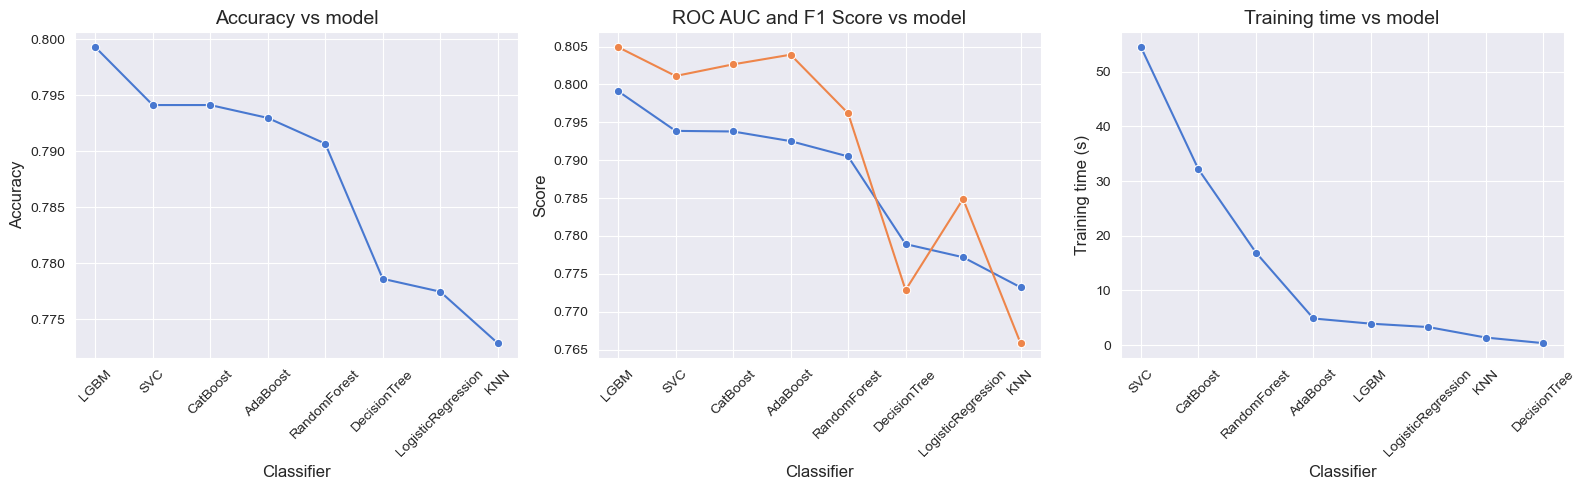

In [82]:
fig = plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
sns.lineplot(data=results.sort_values("Accuracy", ascending=False), x="Classifier", y="Accuracy", marker="o")
plt.title("Accuracy vs model")
plt.xticks(rotation = 45)

plt.subplot(1, 3, 2)
sns.lineplot(data=results.sort_values("ROC AUC", ascending=False), x="Classifier", y="ROC AUC", marker="o")
sns.lineplot(data=results.sort_values("ROC AUC", ascending=False), x="Classifier", y="F1 Score", marker="o")
plt.title("ROC AUC and F1 Score vs model")
plt.xticks(rotation = 45)
plt.ylabel("Score")

plt.subplot(1, 3, 3)
sns.lineplot(data=results.sort_values("Training time (s)", ascending=False), x="Classifier", y="Training time (s)", marker="o")
plt.title("Training time vs model")
plt.xticks(rotation = 45)

fig.tight_layout()
plt.show()

Since SVC and CatBoost had basically the same scores, we'll choose CatBoost to do a cross-validation with LGBM, because it was faster.

In [83]:
clf_best_params

{'LogisticRegression': {'C': 0.75, 'max_iter': 100, 'penalty': 'l2'},
 'DecisionTree': {'criterion': 'entropy', 'max_depth': 8},
 'AdaBoost': {'n_estimators': 50},
 'RandomForest': {'max_depth': 10, 'n_estimators': 250},
 'SVC': {'C': 1.5, 'gamma': 'scale'},
 'KNN': {'n_neighbors': 9, 'p': 1},
 'LGBM': {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150},
 'CatBoost': {'depth': 4, 'iterations': 300, 'learning_rate': 0.1}}

In [84]:
best_classifiers = [
    ("LGBM", LGBMClassifier(**clf_best_params["LGBM"], random_state=42)),
    ("CatBoost", CatBoostClassifier(**clf_best_params["CatBoost"], random_state=42, verbose=False, thread_count=4))
]

# Modelling

We can finally train our best models on the whole training set using cross-validation. 

For this, we can use a technique called stacking, where we stack the probabilities of all predictions (of all models) and take the mean to produce the most confident predictions.

In [85]:
folds = 10
preds = np.empty(len(X_test))

for key, classifier in best_classifiers:
    t0 = time.time()
    
    # 10 fold cross validation
    stk = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    
    score = 0
    for fold, (train_idx, val_idx) in enumerate(stk.split(X, y)):
        # Training and validation sets
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Train the classifier
        clf = classifier
        clf.fit(X_train, y_train)
        
        # Make predictions and measure accuracy
        preds += clf.predict_proba(X_test)[:, 1] # We take just the positive class to stack
        score += clf.score(X_val, y_val) # Stack the score of 10 folds
        
    # Average score
    score = score/folds
    
    t1 = time.time()
    
    # Print accuracy and time
    print("Model:", key)
    print("Average validation accuracy:", np.round(100 * score, 2))
    print("Run time:", "{:.2f} s".format(t1 - t0))
    print("")
    
# Ensemble predictions
preds = preds / (folds * len(best_classifiers)) # Take the mean of all predictions

Model: LGBM
Average validation accuracy: 81.18
Run time: 0.69 s

Model: CatBoost
Average validation accuracy: 81.34
Run time: 6.32 s



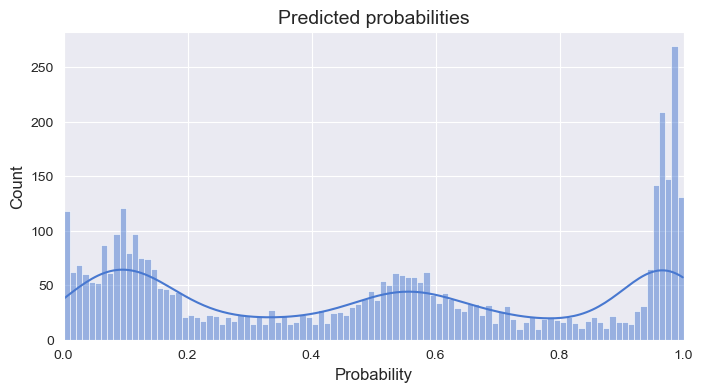

In [86]:
g = sns.histplot(preds, binwidth=0.01, kde=True)
g.set(title="Predicted probabilities", xlabel="Probability", xlim=(0,1))

plt.show()

We can see that our stacked model is very reliable in classifying who was transported and who was not. But the model finds it challenging to classify some passengers, as there is a local maximum close to 0.5.

# Results

We convert each probability into one of the two classes (transported or not), rounding it to the nearest integer (0 or 1) - 1 (or True) means the passenger was transported and 0 (or False) the opposite.

In [87]:
preds_series = pd.Series((preds > 0.5).astype(int), name="Transported")
preds_series.replace({1: True, 0: False}, inplace=True)

final_result = preds_series.value_counts()
target = y.value_counts()

Finally, we can plot the result and compare it with the target.

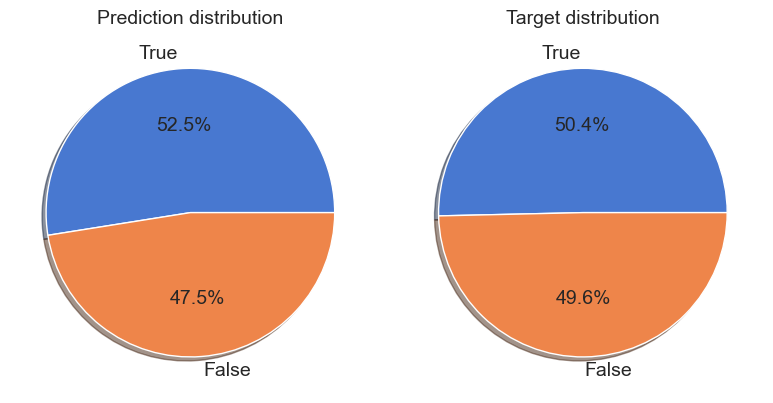

In [88]:
fig = plt.figure()

plt.subplot(1, 2, 1)
plt.pie(final_result, labels=["True", "False"], shadow=True, autopct="%1.1f%%", textprops={"fontsize":14})
plt.title("Prediction distribution")

plt.subplot(1, 2, 2)
plt.pie(target, labels=["True", "False"], shadow=True, autopct="%1.1f%%", textprops={"fontsize":14})
plt.title("Target distribution")

fig.tight_layout()
plt.show()

Our model seems to overestimate a bit the number of transported passengers in the test set. But the predictions are very good.